# Описание проекта
Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# Оглавление:

* [1 Подготовка данных](#One)
    * [1.1 Предобработка пропусков](#OnePointOne)
        * [1.1.1 VehicleType](#OnePointOnePointOne)
        * [1.1.2 Gearbox](#OnePointOnePointTwo)
        * [1.1.3 Model](#OnePointOnePointThree)
        * [1.1.4 FuelType](#OnePointOnePointFour)
        * [1.1.5 NotRepaired](#OnePointOnePointFive)
    * [1.2 Проверка корректность значений в признаках, анализ выбросов](#OnePointTwo)
        * [1.2.1 Price](#OnePointTwoPointOne)
        * [1.2.2 Power](#OnePointTwoPointTwo)
        * [1.2.3 NumberOfPictures](#OnePointTwoPointThree)
        * [1.2.4 RegistrationYear](#OnePointTwoPointFour)
    * [1.3. Кодирование категориальных признаков](#OnePointThree)
* [2 Обучение моделей](#Two)
    * [2.1. LinearRegression](#TwoPointOne)
    * [2.2. Random Forest](#TwoPointTwo)
    * [2.3. LightGBM](#TwoPointThree)
    * [2.4. CatBoost](#TwoPointFour)
    * [2.5 XGBoost](#TwoPointFive)
* [3 Анализ моделей](#Three)
* [4 Общий вывод](#Four)

# 1. Подготовка данных <a class="anchor" id="One"></a>

In [1]:
import pandas as pd
data = pd.read_csv('/datasets/autos.csv')

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt   

from sklearn.preprocessing import OrdinalEncoder

from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score, cross_val_predict , KFold
from sklearn.model_selection import GridSearchCV 


from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import Pool, CatBoostRegressor, cv
from lightgbm import LGBMRegressor
import xgboost as xgb
import time


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


In [4]:
display(data.head(10))

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


  - проверить FuelType: выбросить пустые значения и 0, проверить типы топлива(бъединить петрол и газолайн)
  - проверить все столбцы на 0 и NaN
  - 

 ## 1.1. Предобработка пропусков<a class="anchor" id="OnePointOne"></a>

In [5]:
data.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [6]:
data.isna().mean()

DateCrawled          0.000000
Price                0.000000
VehicleType          0.105794
RegistrationYear     0.000000
Gearbox              0.055967
Power                0.000000
Model                0.055606
Kilometer            0.000000
RegistrationMonth    0.000000
FuelType             0.092827
Brand                0.000000
NotRepaired          0.200791
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
dtype: float64

  - Пропуски есть только в категориальных признаках:
     - Тип кузова - 10,6% пропусков
     - Тип коробки - 5,6%
     - Модель - 5,6%
     - Тип топлива - 9,3%
     - Сведения о ремонте - 20%
 

### 1.1.1 VehicleType<a class="anchor" id="OnePointOnePointOne"></a>

In [7]:
data['VehicleType'].value_counts().head(20)

sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: VehicleType, dtype: int64

 -  Решил заменить пропуски самым популярным вариантом типа кузова - sedan. Как вариант рассматривал другие(other)

### 1.1.2 Gearbox<a class="anchor" id="OnePointOnePointTwo"></a>

In [8]:
data['Gearbox'].value_counts()

manual    268251
auto       66285
Name: Gearbox, dtype: int64

 - Заполним пропуски самым популярным вариантом - manual 

### 1.1.3 Model<a class="anchor" id="OnePointOnePointThree"></a>

In [9]:
data['Model'].value_counts().head(20)

golf           29232
other          24421
3er            19761
polo           13066
corsa          12570
astra          10809
passat         10146
a4              9900
c_klasse        8312
5er             7868
e_klasse        6785
a3              6122
focus           5874
fiesta          5774
a6              5541
twingo          4953
transporter     4822
2_reihe         4816
fortwo          4337
vectra          4254
Name: Model, dtype: int64

 - Пропусков в модели не так много(около 6%). Можно было бы удалить. Но решил заменить вторым по количеству вариантом(other). Другие варианты замен считаю не логичными, т.к. у каждого бренда свои модели.

### 1.1.4 FuelType<a class="anchor" id="OnePointOnePointFour"></a>

In [10]:
data['FuelType'].value_counts().head(20)

petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

 - Здесь так же решил заполнить пропуски самым популярным ответом - petrol

### 1.1.5 NotRepaired<a class="anchor" id="OnePointOnePointFive"></a>

In [11]:
data['NotRepaired'].value_counts().head(20)

no     247161
yes     36054
Name: NotRepaired, dtype: int64

 - Наличие на рынке машин без ремонта очень небольшое. Поэтому пропуск можно расценивать, как желание скрыть информацию. Поэтому решил заменить самым популярным ответом - no.

In [12]:
# Функция для заполнения пропусков
def missing_values(data):
    data['Model'] = data['Model'].fillna('other')     
    data['VehicleType'].fillna(data['VehicleType'].mode()[0], inplace=True)
    data['Gearbox'].fillna(data['Gearbox'].mode()[0], inplace=True)    
    data['FuelType'].fillna(data['FuelType'].mode()[0], inplace=True)
    data['NotRepaired'].fillna(data['NotRepaired'].mode()[0], inplace=True)   
    return data


## 1.2. Проверка корректность значений в признаках, анализ выбросов<a class="anchor" id="OnePointTwo"></a>

In [13]:
data_numbers = data.drop(['DateCrawled', 'LastSeen', 'DateCreated', 'PostalCode'], axis = 1)
#посмотрим на числовые столбцы
data_numbers.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0


 - в столбцах Price, Power, RegistrationMonth есть нули, их нужно обработать
 - в столбце RegistrationYear видим аномальные значения - 1000 и 9999
 - в столбце NumberOfPictures все значения нули, удалим его

### 1.2.1 Price<a class="anchor" id="OnePointTwoPointOne"></a>

In [14]:
data['Price'].value_counts().head(10)

0       10772
500      5670
1500     5394
1000     4649
1200     4594
2500     4438
600      3819
3500     3792
800      3784
2000     3431
Name: Price, dtype: int64

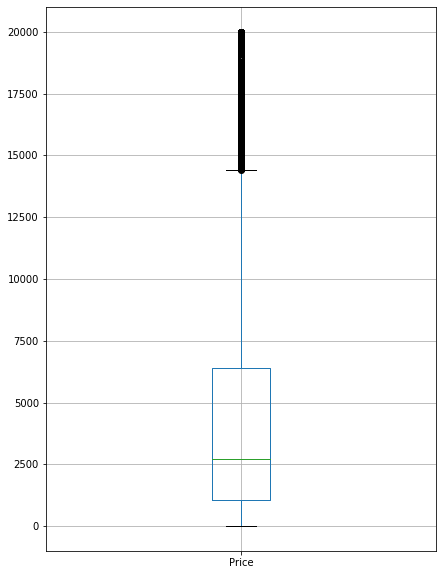

In [15]:
plt.figure(figsize =(7,10))
data.boxplot(column='Price')
plt.show()

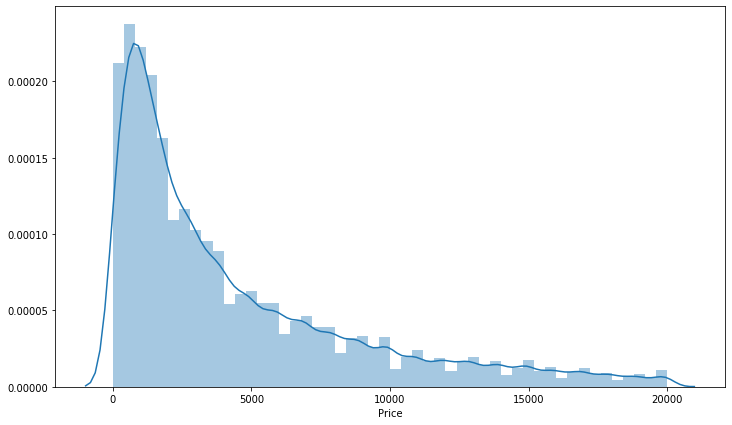

In [16]:
plt.figure(figsize =(12,7))
sns.distplot(data['Price']);

 - В столбце со стоимостью много значений с ценой 0. Это равнозначно пропуску, удалим строки с нулевой ценой и выбросы больше 15000.

### 1.2.2 Power<a class="anchor" id="OnePointTwoPointTwo"></a>

In [17]:
data['Power'].value_counts().head(20)

0      40225
75     24023
60     15897
150    14590
101    13298
140    12852
90     12734
116    11918
105    10355
170    10121
125     6965
136     6752
102     6451
163     6081
54      5745
143     5300
122     5125
131     5108
109     4777
110     4729
Name: Power, dtype: int64

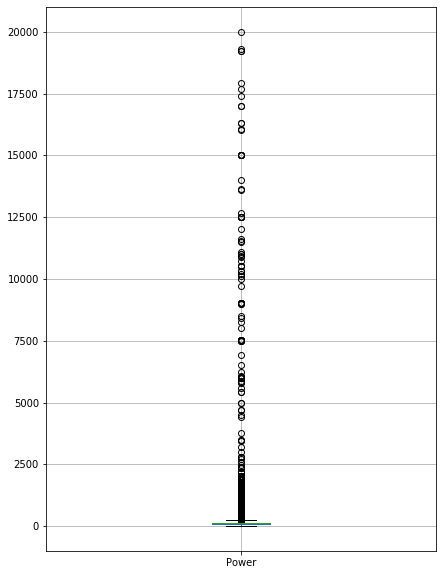

In [18]:
plt.figure(figsize =(7,10))
data.boxplot(column='Power')
plt.show()

 - Удалим значения мощности с 0 и значения выше 500

### 1.2.3 NumberOfPictures<a class="anchor" id="OnePointTwoPointThree"></a>

In [19]:
data['NumberOfPictures'].value_counts().head(10)

0    354369
Name: NumberOfPictures, dtype: int64

- В столбце о фотографиях только нули. Это никак не коррелирует с прайсом. Удалим его
- Так же столбца с датами, месяц регистрации и почтовый индекс почти не влияют на прайс(DateCrawled, DateCreated,	PostalCode,	LastSeen). Удалим их

### 1.2.4 RegistrationYear<a class="anchor" id="OnePointTwoPointFour"></a>

In [20]:
data['RegistrationYear'].value_counts().head(30)

2000    24490
1999    22728
2005    22109
2001    20124
2006    19900
2003    19763
2004    19611
2002    19092
1998    17899
2007    17183
2008    15391
1997    14666
2009    14503
1996    10835
2010    10764
2017    10441
2011     9909
1995     9607
2016     9599
2012     7178
1994     4841
2013     4131
2018     3959
1993     3438
1992     3002
1990     2806
1991     2762
2014     2537
1989     1318
2015     1302
Name: RegistrationYear, dtype: int64

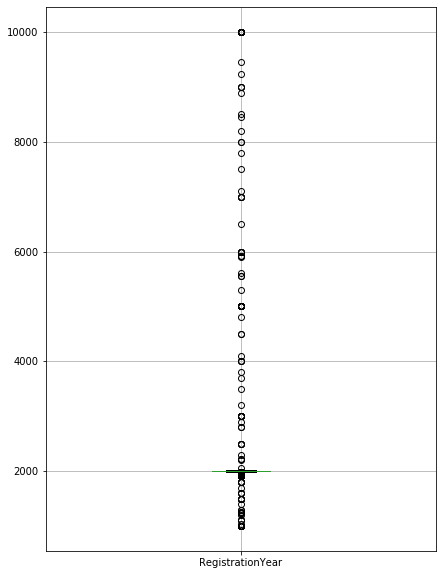

In [21]:
plt.figure(figsize =(7,10))
data.boxplot(column='RegistrationYear')
plt.show()

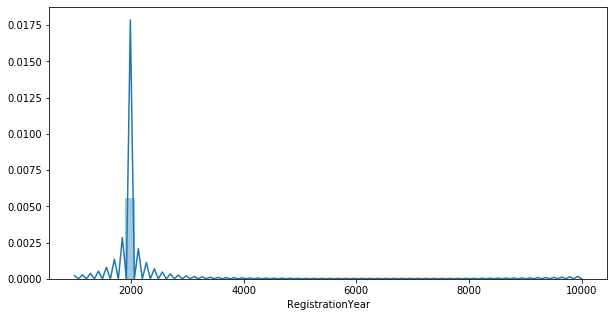

In [22]:
plt.figure(figsize =(10,5))
sns.distplot(data['RegistrationYear']);

- удалим выбросы и аномальные значение в столбце RegistrationYear. Это значения меньше 1950г. и больше 2020г.

In [23]:
# Функция удаления выбросов, аномалий и малоинформативных данных
def outliers_remove(data):
    data = data.query('0 < Price < 15000')
    data = data.query('0 < Power < 500')
    data = data.drop(['NumberOfPictures', 'DateCrawled','DateCreated', 
                            'PostalCode', 'LastSeen', 'RegistrationMonth'], axis = 1)
    data = data.query('1950 < RegistrationYear < 2020')
    return data


In [24]:
missing_values(data)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,sedan,1993,manual,0,golf,150000,0,petrol,volkswagen,no,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,other,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,sedan,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,sedan,2005,manual,0,other,20000,1,petrol,sonstige_autos,no,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


In [25]:
outliers_remove(data)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,no
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no
...,...,...,...,...,...,...,...,...,...,...
354361,5250,sedan,2016,auto,150,159,150000,petrol,alfa_romeo,no
354362,3200,sedan,2004,manual,225,leon,150000,petrol,seat,yes
354366,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
354367,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


In [26]:
# Предобработаем данные
data = missing_values(data)

In [27]:
data = outliers_remove(data).reset_index(drop=True)

## 1.3. Кодирование категориальных признаков<a class="anchor" id="OnePointTwoPointThree"></a>

In [28]:
# Функция кодирования категориальных данных
def ohe(data):
    categorical_features = ['VehicleType' , 'Gearbox' , 'Model' , 'FuelType' , 'Brand' , 'NotRepaired']
    encoder = OrdinalEncoder(dtype = 'int64')
    data_encoded = encoder.fit_transform(data[categorical_features])   
    df_encoded = pd.DataFrame(data = data_encoded, columns = categorical_features)
    return pd.concat([df_encoded, data[set(data.columns)-set(categorical_features)]] , axis=1) 

In [29]:
ohe(data)

,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired,RegistrationYear,Kilometer,Power,Price
0,6,0,117,2,14,0,2004,125000,163,9800
1,5,1,116,6,38,0,2001,150000,75,1500
2,5,1,101,2,31,0,2008,90000,69,3600
3,4,1,11,6,2,1,1995,150000,102,650
4,1,1,8,6,25,0,2004,150000,109,2200
...,...,...,...,...,...,...,...,...,...,...
291747,4,0,4,6,0,0,2016,150000,150,5250
291748,4,1,140,6,30,1,2004,150000,225,3200
291749,1,0,106,6,32,0,2000,125000,101,1199
291750,0,1,223,2,38,0,1996,150000,102,9200


In [30]:
data_clear = ohe(data)

In [31]:
# Проверим итоговую корреляцию признаков с ценой
corr_matrix = abs(data_clear.corr())  # Рассматриваем абсолютное значение корреляции
corr = corr_matrix.sort_values(by='Price' , ascending = False)
corr

,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired,RegistrationYear,Kilometer,Power,Price
Price,0.078626,0.220216,0.039457,0.293381,0.097077,0.195993,0.418560,0.333550,0.469193,1.000000
Power,0.014298,0.412927,0.145443,0.207799,0.330321,0.030751,0.081378,0.151508,1.000000,0.469193
RegistrationYear,0.030042,0.008662,0.007539,0.203121,0.005729,0.080643,1.000000,0.224563,0.081378,0.418560
Kilometer,0.037564,0.028281,0.038039,0.164778,0.051038,0.065121,0.224563,1.000000,0.151508,0.333550
FuelType,0.042310,0.133275,0.021617,1.000000,0.027592,0.026868,0.203121,0.164778,0.207799,0.293381
Gearbox,0.037047,1.000000,0.049943,0.133275,0.103794,0.009494,0.008662,0.028281,0.412927,0.220216
NotRepaired,0.019011,0.009494,0.012929,0.026868,0.009966,1.000000,0.080643,0.065121,0.030751,0.195993
Brand,0.046627,0.103794,0.456080,0.027592,1.000000,0.009966,0.005729,0.051038,0.330321,0.097077
VehicleType,1.000000,0.037047,0.139686,0.042310,0.046627,0.019011,0.030042,0.037564,0.014298,0.078626
Model,0.139686,0.049943,1.000000,0.021617,0.456080,0.012929,0.007539,0.038039,0.145443,0.039457


## Вывод

**Проверка и обработка пропусков**
- VehicleType. Пропуски заполнил модой, т.к. это меньше всего искажает реальную картину.
- Gearbox. Пропуски заполнил модой, т.к. самое популярное значение содержит почти 80% датасета.
- FuelType. Так же пропуски заполнил модой, этого значения более 60%.
- Model. Зменил вторым по количеству вариантом(other). Другие варианты замен считаю не логичными, т.к. у каждого бренда свои модели.
- NotRepaired. Зменил модой, т.к. машин с ремонтом значительно больше.

**Проверка корректность значений в признаках, посмотрим на выбросы**
- NumberOfPictures. Удалил признак, т.к. все значения нулевые.
- DateCrawled, DateCreated, PostalCode, LastSeen. Так же удалил, т.к. эти данные почти не влияют на прайс.
- Price. Удалил строки с нулевой ценой и выбросы больше 15000.
- Power. Удалил значения мощности с 0 и значения выше 500.
- RegistrationYear. Удалил выбросы и аномальные значения. Это значения меньше 1950г. и больше 2020г.

**Кодирование категориальных признаков**

- Методом OrdinalEncoder() строковые значения преобразованы в числовые. Таким образом каждые признак состоит из числовых значений.



# 2. Обучение моделей<a class="anchor" id="Two"></a>

In [32]:
features = data_clear.drop(['Price'], axis = 1)
target = data_clear['Price']

features_train, features_test, target_train, target_test = train_test_split(
                                                             features, target, test_size=0.3, random_state=12345)

In [33]:
print('Размеры матриц и векторов')
features_train.shape , target_train.shape , features_test.shape, target_test.shape

Размеры матриц и векторов


((204226, 9), (204226,), (87526, 9), (87526,))

## 2.1. LinearRegression<a class="anchor" id="TwoPointOne"></a>

In [34]:
%%time
start_time = time.time()

lr_model = LinearRegression()

# Значения метрики на кросс валидации
lr_cv_rmse = (cross_val_score(lr_model, 
                             features_train, 
                             target_train, 
                             cv=5, 
                             scoring='neg_mean_squared_error').mean()*-1)**0.5
print('Значение RMSE для LinearRegression на train =', lr_cv_rmse)

lr_cv_time = time.time() - start_time

Значение RMSE для LinearRegression на train = 2496.9166612700305
CPU times: user 511 ms, sys: 329 ms, total: 840 ms
Wall time: 827 ms


In [35]:
%%time
start_time = time.time()

lr_model.fit(features_train, target_train)

lr_rmse = mean_squared_error(target_test, lr_model.predict(features_test))**0.5

print('Значение RMSE для LinearRegression на test =' , lr_rmse)

lr_time = time.time() - start_time # Записываем время работы ячейки

Значение RMSE для LinearRegression на test = 2510.334973537261
CPU times: user 125 ms, sys: 65.4 ms, total: 190 ms
Wall time: 200 ms


## 2.2. Random Forest<a class="anchor" id="TwoPointTwo"></a>

In [36]:
%%time
start_time = time.time()
# Подберем параметры
rf_model = RandomForestRegressor(random_state = 12345) 

hyperparametrs = [{'n_estimators':[50, 80],'max_depth':[10,14]}]

grid_rf = GridSearchCV(rf_model, hyperparametrs, cv=5)
grid_rf.fit(features_train, target_train)
print(grid_rf.best_params_)
rf_cv_time_1 = time.time() - start_time

{'max_depth': 14, 'n_estimators': 80}
CPU times: user 6min 15s, sys: 519 ms, total: 6min 16s
Wall time: 6min 18s


In [37]:
%%time
start_time = time.time()

rf_model = RandomForestRegressor( max_depth=14, n_estimators=80, random_state = 12345) 
# Значения метрики на кросс валидации

rf_cv_rmse = (cross_val_score(rf_model , 
                            features_train, 
                            target_train , 
                            cv=5 , 
                            scoring='neg_mean_squared_error').mean()*-1)**0.5

print('Значение RMSE для Random Forest на train:' , rf_cv_rmse)

rf_cv_time_2 = time.time() - start_time # Записываем время работы ячейки

Значение RMSE для Random Forest на train: 1449.6126287242878
CPU times: user 1min 58s, sys: 684 ms, total: 1min 58s
Wall time: 1min 59s


In [38]:
rf_cv_time = rf_cv_time_1 + rf_cv_time_2

In [39]:
%%time
# Модель на тестовой выборке
start_time = time.time()

rf_model.fit(features_train, target_train)
rf_rmse = mean_squared_error(target_test, grid_rf.predict(features_test))**0.5

print('Значение RMSE для Random Forest на test:' , rf_rmse)

rf_time = time.time() - start_time # Записываем время работы ячейки 

Значение RMSE для Random Forest на test: 1451.9944268721956
CPU times: user 28.6 s, sys: 144 ms, total: 28.8 s
Wall time: 28.9 s


## 2.3. LightGBM<a class="anchor" id="TwoPointThree"></a>

In [49]:
%%time
start_time = time.time()

LGBM = LGBMRegressor(random_state=12345, learning_rate=0.1) 
hyperparams = [{'num_leaves':[200, 400], 
                'max_depth':[10, 12, 14],
                'min_data_in_leaf':[10, 100, 200]}]

grid_lgbm = GridSearchCV(LGBM, hyperparams, scoring='neg_mean_squared_error', cv=5)
grid_lgbm.fit(features_train, target_train)

print('Лучшие гиперпараметры:')
print()
print(grid_lgbm.best_params_)
print()
print("RMSE при разных значениях гиперпараметров:")
print()
means = grid_lgbm.cv_results_['mean_test_score']
stds = grid_lgbm.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_lgbm.cv_results_['params']):
    print("%0.4f for %r"% ((mean*-1)** 0.5, params))
print()

lgbm_cv_rmse = (max(means)*-1) ** 0.5
lgbm_cv_time = time.time() - start_time # Записываем время работы ячейки 

Лучшие гиперпараметры:

{'max_depth': 14, 'min_data_in_leaf': 10, 'num_leaves': 400}

RMSE при разных значениях гиперпараметров:

1384.0930 for {'max_depth': 10, 'min_data_in_leaf': 10, 'num_leaves': 200}
1374.1154 for {'max_depth': 10, 'min_data_in_leaf': 10, 'num_leaves': 400}
1411.6975 for {'max_depth': 10, 'min_data_in_leaf': 100, 'num_leaves': 200}
1409.5990 for {'max_depth': 10, 'min_data_in_leaf': 100, 'num_leaves': 400}
1430.8605 for {'max_depth': 10, 'min_data_in_leaf': 200, 'num_leaves': 200}
1429.8875 for {'max_depth': 10, 'min_data_in_leaf': 200, 'num_leaves': 400}
1378.9639 for {'max_depth': 12, 'min_data_in_leaf': 10, 'num_leaves': 200}
1364.1715 for {'max_depth': 12, 'min_data_in_leaf': 10, 'num_leaves': 400}
1402.7763 for {'max_depth': 12, 'min_data_in_leaf': 100, 'num_leaves': 200}
1397.2860 for {'max_depth': 12, 'min_data_in_leaf': 100, 'num_leaves': 400}
1422.0308 for {'max_depth': 12, 'min_data_in_leaf': 200, 'num_leaves': 200}
1420.6662 for {'max_depth': 12, 'min_d

In [50]:
%%time
# Модель на тестовой выборке
start_time = time.time()
model = LGBMRegressor(random_state=12345, learning_rate=0.1, depth=14, min_data_in_leaf=10, num_leaves=400)

# Обучаем модель
model.fit(features_train, target_train)  
# Делаем предсказания
preds = model.predict(features_test)
lgbm_rmse = mean_squared_error(target_test, preds)**0.5

print('Значение RMSE для LightGBM на test:', lgbm_rmse)

lgbm_time = time.time() - start_time # Записываем время работы ячейки

Значение RMSE для LightGBM на test: 1353.6053884550602
CPU times: user 6.56 s, sys: 76.8 ms, total: 6.64 s
Wall time: 6.64 s


## 2.4. CatBoost<a class="anchor" id="TwoPointFour"></a>

In [51]:
%%time
start_time = time.time()

CatBST = CatBoostRegressor(random_state=12345) 
hyperparams = [{'iterations': [200, 500],
                'learning_rate':[0.1], # 0.5
                'depth': [12, 14],
                'verbose':[False]}]

grid_cat = GridSearchCV(CatBST, hyperparams, scoring='neg_mean_squared_error')
grid_cat.fit(features_train, target_train)
print("Лучшие гиперпараметры::")
print()
print(grid_cat.best_params_)
print()
print("RMSE при разных значениях гиперпараметров:")
print()
means = grid_cat.cv_results_['mean_test_score']
stds = grid_cat.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_cat.cv_results_['params']):
    print("%0.4f for %r"% ((mean*-1)** 0.5, params))
print()
catboost_cv_rmse = (max(means)*-1) ** 0.5
catboost_cv_time = time.time() - start_time # Записываем время работы ячейки 

Лучшие гиперпараметры::

{'depth': 14, 'iterations': 500, 'learning_rate': 0.1, 'verbose': False}

RMSE при разных значениях гиперпараметров:

1405.6633 for {'depth': 12, 'iterations': 200, 'learning_rate': 0.1, 'verbose': False}
1372.6675 for {'depth': 12, 'iterations': 500, 'learning_rate': 0.1, 'verbose': False}
1392.4707 for {'depth': 14, 'iterations': 200, 'learning_rate': 0.1, 'verbose': False}
1366.8191 for {'depth': 14, 'iterations': 500, 'learning_rate': 0.1, 'verbose': False}

CPU times: user 29min 13s, sys: 3min 30s, total: 32min 43s
Wall time: 33min 1s


In [43]:
%%time
# Модель на тестовой выборке
start_time = time.time()
model = CatBoostRegressor(iterations = 500, learning_rate = 0.1, depth = 12, verbose=False)

# Обучаем модель
model.fit(features_train, target_train)  
# Делаем предсказания
preds = model.predict(features_test)
catboost_rmse = mean_squared_error(target_test, preds)**0.5

print('Значение RMSE для CatBoost на test:', catboost_rmse)

catboost_time = time.time() - start_time # Записываем время работы ячейки в переменную

Значение RMSE для CatBoost на test: 1362.3299244279856
CPU times: user 2min 22s, sys: 15.4 s, total: 2min 38s
Wall time: 2min 40s


##  2.5. XGBoost<a class="anchor" id="TwoPointFive"></a>

In [47]:
%%time
start_time = time.time()
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

xgb_model = xgb.XGBRegressor(objective ='reg:squarederror', gpu_id=0, random_state = 12345)

hyperparametrs = { 'max_depth': [10, 12, 14],
                'n_estimators': [100, 200]}

grid_xgbst = GridSearchCV(xgb_model, hyperparametrs, scoring='neg_mean_squared_error', cv=5)
model_xgboost = grid_xgbst.fit(features_train, target_train)

print('Лучшие гиперпараметры:')
print()
print(grid_xgbst.best_params_)
print()
#predict = model_xgboost.predict(features_valid)
#print("RMSE", (mean_squared_error(target_valid, predict))**.5)
print("RMSE при разных значениях гиперпараметров:")
print()
means = grid_xgbst.cv_results_['mean_test_score']
stds = grid_xgbst.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_xgbst.cv_results_['params']):
    print("%0.4f for %r"% ((mean*-1)** 0.5, params))
print()
xgboost_cv_rmse = (max(means)*-1) ** 0.5
xgboost_cv_time = time.time() - start_time # Записываем время работы ячейки


Лучшие гиперпараметры:

{'max_depth': 10, 'n_estimators': 200}

RMSE при разных значениях гиперпараметров:

1369.0407 for {'max_depth': 10, 'n_estimators': 100}
1352.8644 for {'max_depth': 10, 'n_estimators': 200}
1360.7265 for {'max_depth': 12, 'n_estimators': 100}
1358.7725 for {'max_depth': 12, 'n_estimators': 200}
1379.0125 for {'max_depth': 14, 'n_estimators': 100}
1386.9425 for {'max_depth': 14, 'n_estimators': 200}

CPU times: user 30min 27s, sys: 0 ns, total: 30min 27s
Wall time: 30min 31s


In [48]:
%%time

# Модель на тестовой выборке
start_time = time.time()
model = xgb.XGBRegressor(objective ='reg:squarederror', max_depth=10, n_estimators=200, gpu_id=0, random_state = 12345)

# Обучаем модель
model.fit(features_train, target_train)  
# Делаем предсказания
preds = model.predict(features_test)
xgboost_rmse = mean_squared_error(target_test, preds)**0.5

print('Значение  RMSE для XGBoost на test:', xgboost_rmse)

xgboost_time = time.time() - start_time # Записываем время работы ячейки

Значение  RMSE для XGBoost на test: 1349.467833383851
CPU times: user 1min 17s, sys: 0 ns, total: 1min 17s
Wall time: 1min 18s


# 3. Анализ моделей<a class="anchor" id="Three"></a>

Для анализа использовали модели: LinearRegression, Random Forest , LightGBM , CatBoost, XGBoost.

In [52]:
# Записываем результаты в словарь
dict_results = {'Model': ['LinearRegression,' , 'Random_Forest' , 'LightGBM' , 'CatBoost','XGBoost'],
               'RMSE_CV':[lr_cv_rmse , rf_cv_rmse , lgbm_cv_rmse , catboost_cv_rmse, xgboost_cv_rmse] ,
               'RMSE_test': [lr_rmse , rf_rmse , lgbm_rmse , catboost_cv_rmse, xgboost_rmse] , 
               'Working_time_CV' : [lr_cv_time , rf_cv_time , lgbm_cv_time , catboost_cv_time, xgboost_cv_time ],
               'Working_time_test': [lr_time , rf_time , lgbm_time , catboost_time, xgboost_time] ,
               } 
Results = pd.DataFrame(dict_results)
Results

,Model,RMSE_CV,RMSE_test,Working_time_CV,Working_time_test
0,"LinearRegression,",2496.916661,2510.334974,0.827340,0.199473
1,Random_Forest,1449.612629,1451.994427,497.907567,28.928509
2,LightGBM,1360.000478,1353.605388,398.019591,6.638592
3,CatBoost,1366.819147,1366.819147,1981.181689,160.310238
4,XGBoost,1352.864426,1349.467833,1831.973081,78.079432


# 4. Общий Вывод<a class="anchor" id="Four"></a>

- Для модели LinearRegression не использовал подбор параметров.
- Для модели Random Forest подбирал значения параметров: *n_estimators и max_depth.*
- Для модели LightGBM подбирал значения параметров: *num_leaves, max_depth, min_data_in_leaf.*
- Для модели CatBoost подбирал значения параметров: *iterations, learning_rate, depth.*
- Для модели XGBoost подбирал значения параметров:  *max_depth, n_estimators*
_______________________________________________
1. Лучшее качество показала модель XGBoost. На втором месте по качеству LightGBM, на третьем - CatBoost. 
2. Лучшая скорость работы модели LinearRegression. На втором месте - LightGBM, на третьем - Random Forest.
3. Самое низкое качество показала модель LinearRegression.
4. Самая низка скорость работы у CatBoost.

**Итого: Лучший показатель в соотношении качество/скорость у модели LightGBM, на втором месте XGBoost**

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнена загрузка и подготовка данных
- [ ]  Выполнено обучение моделей
- [ ]  Есть анализ скорости работы и качества моделей